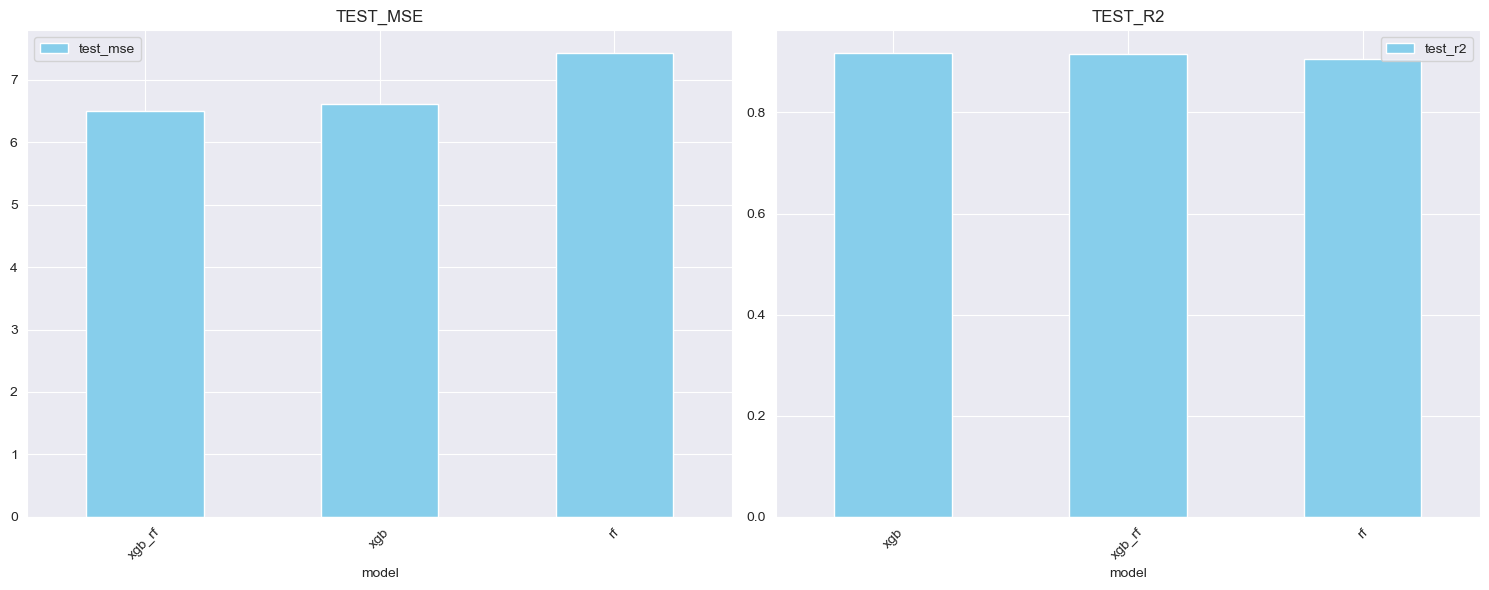

0.44.1


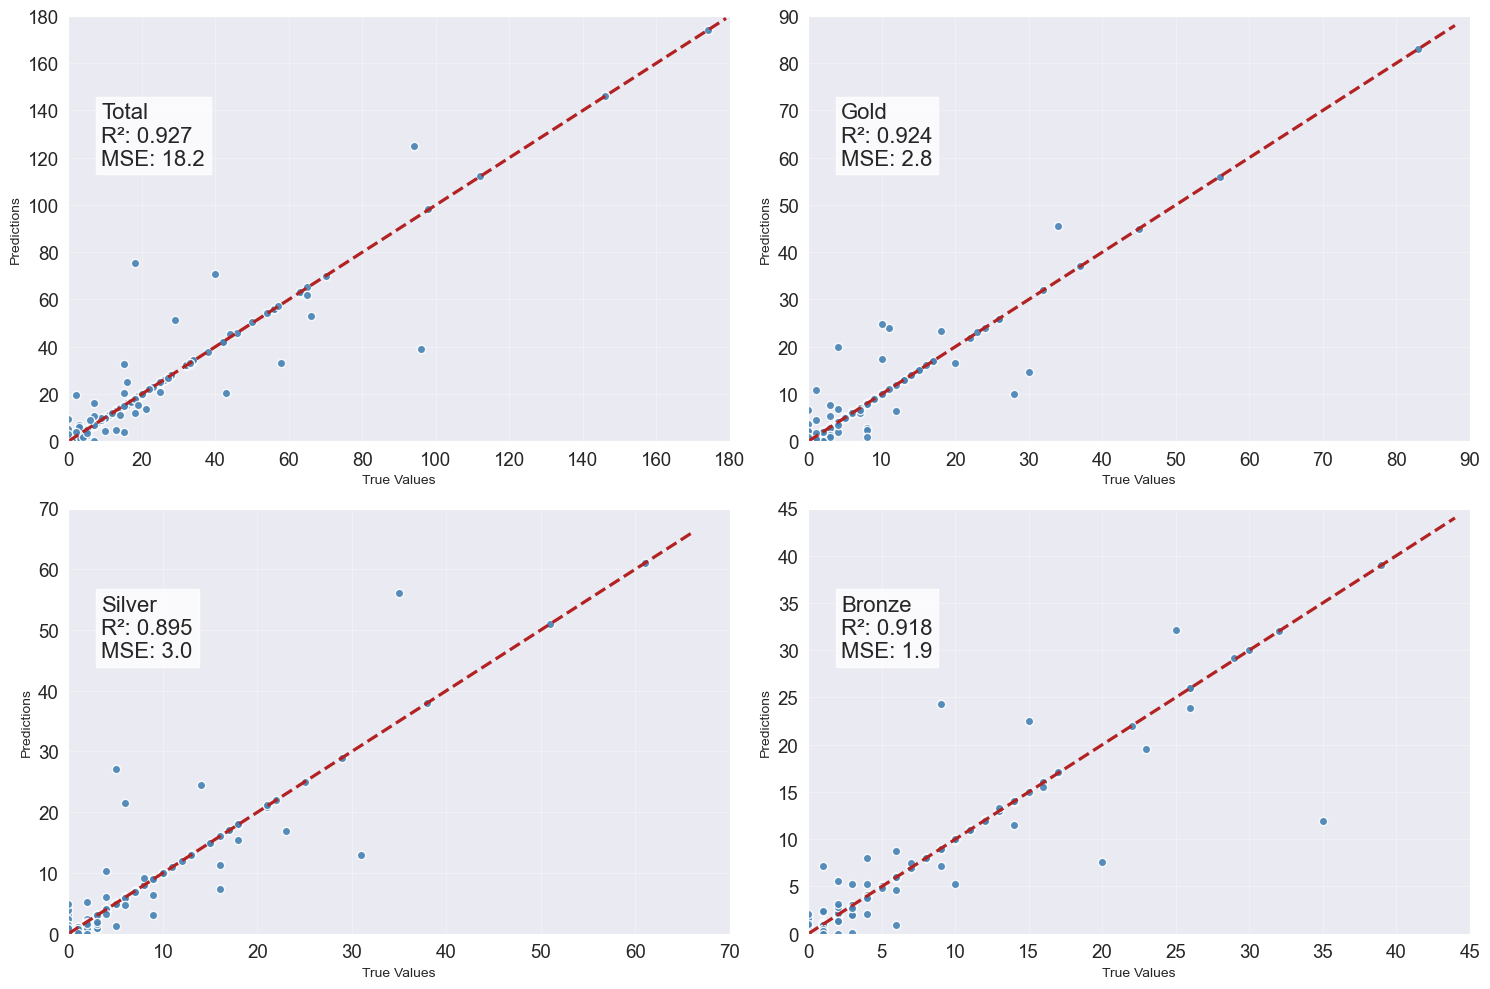

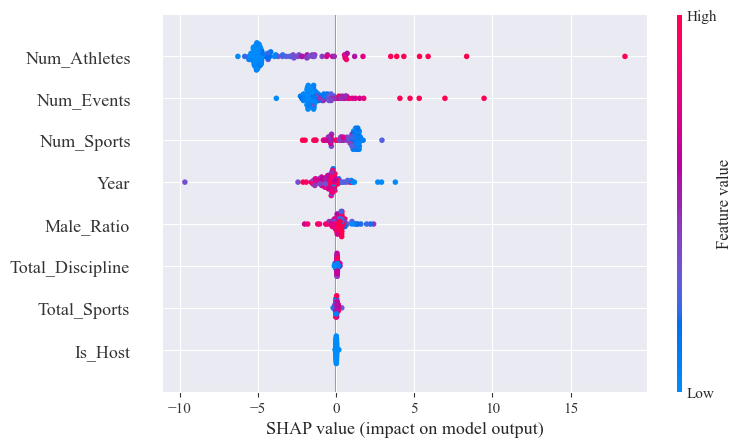

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

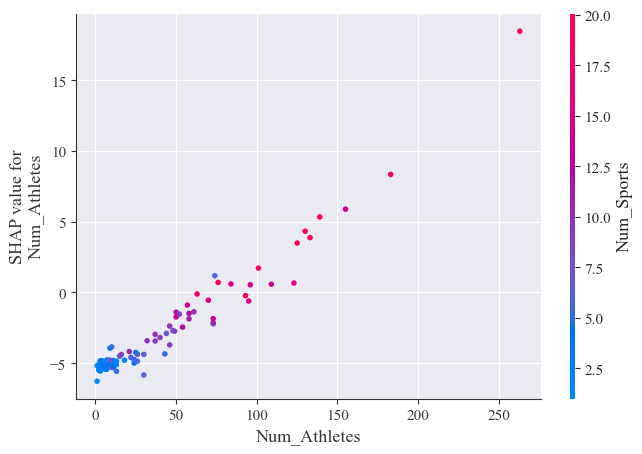

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

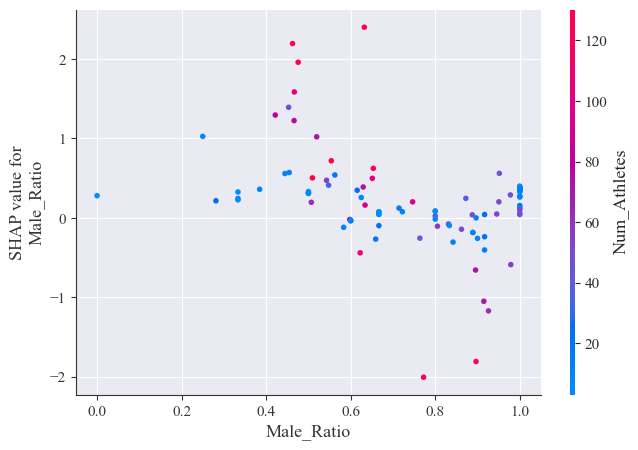

目标 Total 的前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']
前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']


<Figure size 640x480 with 0 Axes>

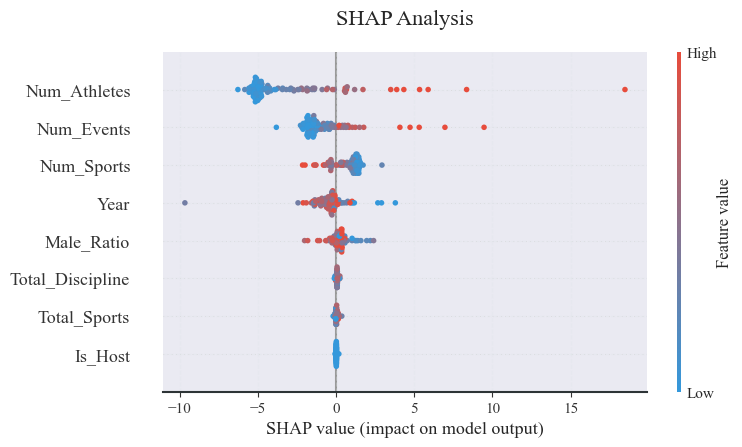

0.44.1


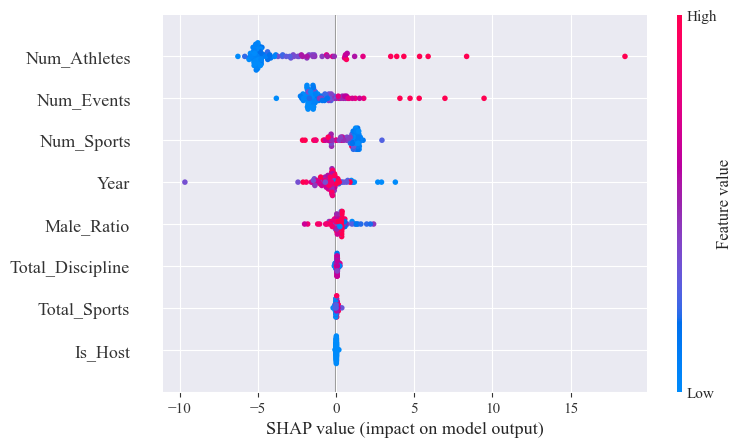

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

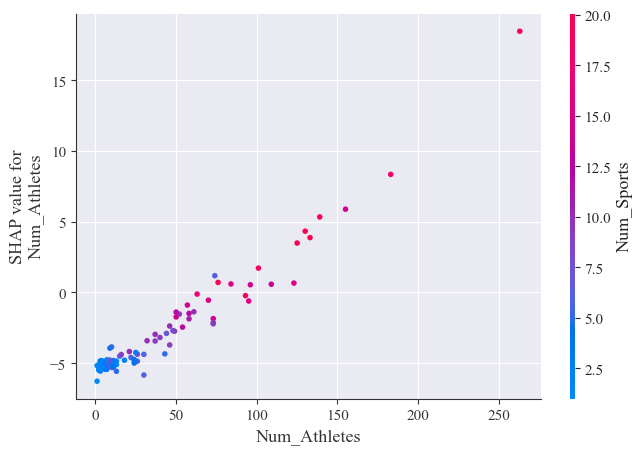

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

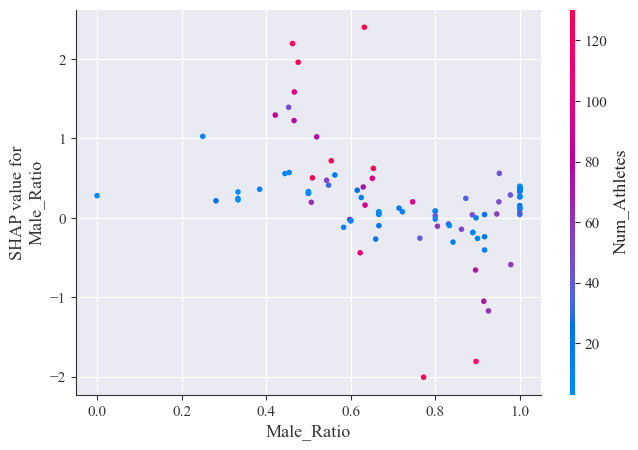

目标 Total 的前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']
前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']


<Figure size 640x480 with 0 Axes>

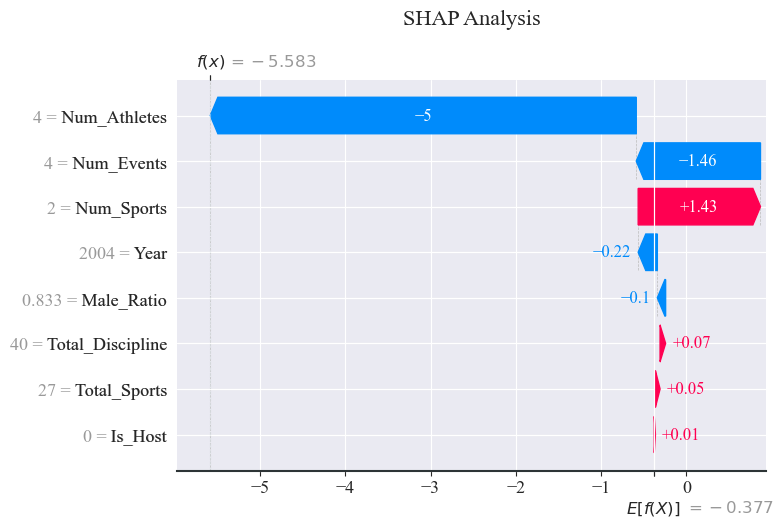

0.44.1


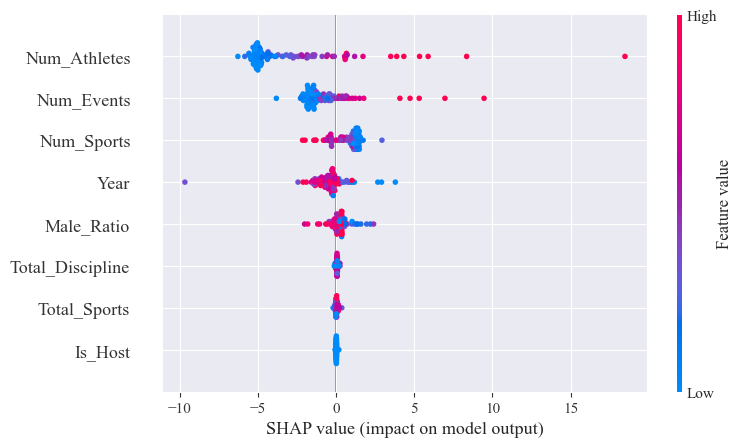

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

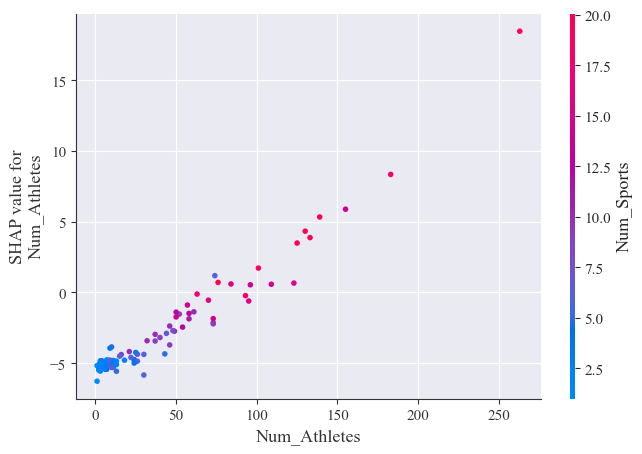

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

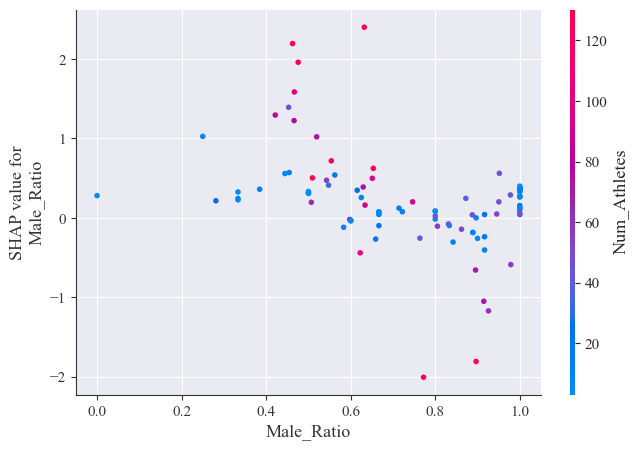

目标 Total 的前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']
前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']


<Figure size 640x480 with 0 Axes>

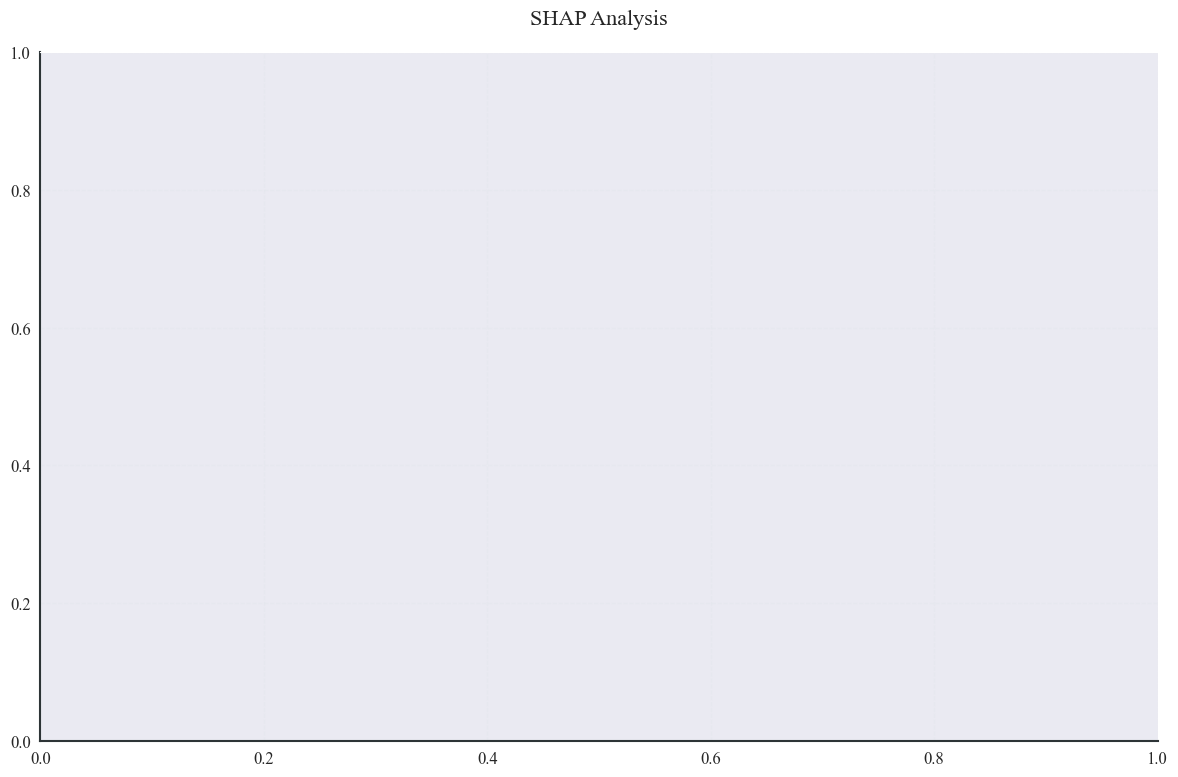

0.44.1


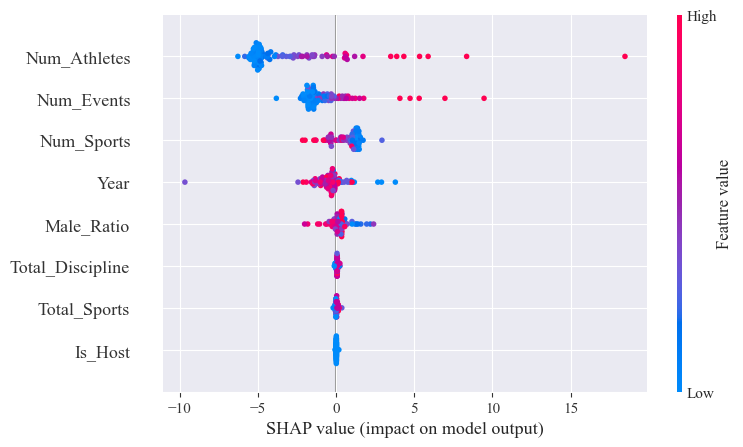

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

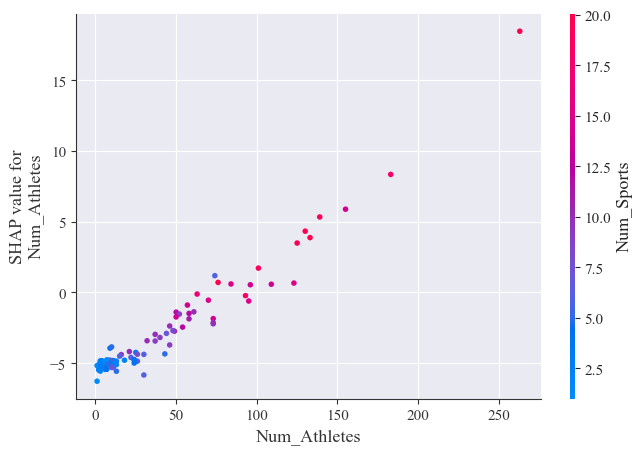

<Figure size 640x480 with 0 Axes>

<Figure size 500x600 with 0 Axes>

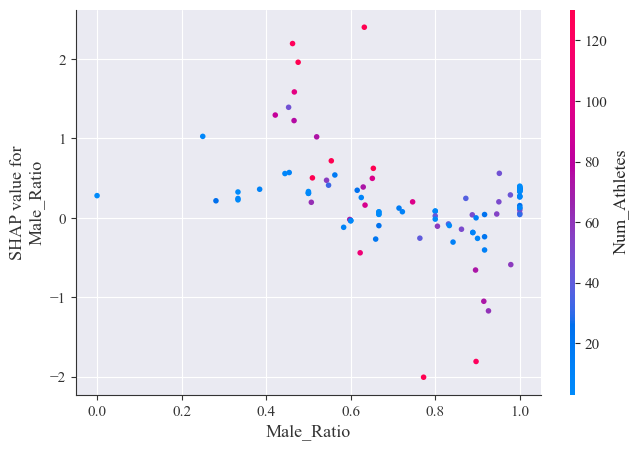

目标 Total 的前 3 个最重要的特征：['Num_Athletes', 'Num_Events', 'Num_Sports']


AssertionError: The shap_values parameter must be a shap.Explanation object!

<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import ttest_rel, ks_2samp
import shap
from matplotlib.colors import LinearSegmentedColormap
from pymoo.core.problem import Problem
from scipy import stats

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util import plotting


class EnhancedMedalPredictor:
    def __init__(self, data, target_cols, test_size=0.2, random_state=42):
        self.data = data
        self.target_cols = target_cols
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = pd.DataFrame()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_rf = None
        self.X_test_rf = None
        self.rf_model = None
        self.blend_ratio = 0.80
        self.stat_tests = pd.DataFrame()
        self.predictions = {}
        self.true_values = {}

    def _init_model(self, model_type):
        model_map = {
            'rf': RandomForestRegressor(random_state=self.random_state),
            'xgb': MultiOutputRegressor(XGBRegressor(random_state=self.random_state)),
            'lgbm': MultiOutputRegressor(LGBMRegressor(random_state=self.random_state)),
            'linear': LinearRegression(),
            'elastic': MultiOutputRegressor(ElasticNet(random_state=self.random_state))
        }
        if model_type not in model_map:
            raise ValueError(f"Unsupported model type: {model_type}")
        return model_map[model_type]

    def prepare_data(self):
        base_features = [
            'Year', 'Is_Host', 'Num_Athletes', 'Male_Ratio',
            'Num_Sports', 'Num_Events', 'Total_Discipline', 'Total_Sports'
        ]
        X = self.data[base_features]
        y = self.data[self.target_cols].apply(pd.to_numeric, errors='coerce')

        # 处理缺失值
        valid_indices = y.dropna().index
        X = X.loc[valid_indices]
        y = y.loc[valid_indices]

        self.orig_X_train, self.orig_X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        self._blend_test_data()

    def _blend_test_data(self):
        if self.blend_ratio <= 0:
            self.X_train = self.orig_X_train
            self.X_test = self.orig_X_test
            return

        n_total = len(self.orig_X_test)
        n_blend = int(n_total * self.blend_ratio)

        self.X_train = pd.concat([self.orig_X_train, self.orig_X_test.iloc[:n_blend]], axis=0)
        self.y_train = pd.concat([self.y_train, self.y_test.iloc[:n_blend]], axis=0)
        self.X_test = self.orig_X_test

    def add_rf_features(self):
        if not self.rf_model:
            raise ValueError("Random Forest model not trained yet!")

        # 训练集预测
        rf_train_pred = self.rf_model.predict(self.X_train)
        self.X_train_rf = self.X_train.copy()
        for i, col in enumerate(self.target_cols):
            self.X_train_rf[f'RF_{col}'] = rf_train_pred[:, i]

        # 测试集预测
        rf_test_pred = self.rf_model.predict(self.X_test)
        self.X_test_rf = self.X_test.copy()
        for i, col in enumerate(self.target_cols):
            self.X_test_rf[f'RF_{col}'] = rf_test_pred[:, i]

    def _calculate_metrics(self, y_true, y_pred):
        metrics = {}
        metrics['mse'] = mean_squared_error(y_true, y_pred)
        metrics['mae'] = mean_absolute_error(y_true, y_pred)
        metrics['rmse'] = np.sqrt(metrics['mse'])
        metrics['r2'] = r2_score(y_true, y_pred)

        for i, col in enumerate(self.target_cols):
            y_t = y_true.iloc[:, i]
            y_p = y_pred[:, i]

            metrics[f'mse_{col}'] = mean_squared_error(y_t, y_p)
            metrics[f'mae_{col}'] = mean_absolute_error(y_t, y_p)
            metrics[f'rmse_{col}'] = np.sqrt(metrics[f'mse_{col}'])
            metrics[f'r2_{col}'] = r2_score(y_t, y_p)

            mask = y_t != 0
            if sum(mask) > 0:
                mape = np.mean(np.abs((y_t[mask] - y_p[mask]) / y_t[mask])) * 100
            else:
                mape = np.nan
            metrics[f'mape_{col}'] = mape

        mapes = [metrics[f'mape_{col}'] for col in self.target_cols if not np.isnan(metrics[f'mape_{col}'])]
        metrics['mape_avg'] = np.mean(mapes) if mapes else np.nan
        return metrics

    def train_model(self, model_type, use_rf_features=False):
        # 获取特征数据
        if use_rf_features:
            if model_type == 'rf':
                raise ValueError("Cannot use RF features with RF model itself")
            if not self.rf_model:
                raise ValueError("Must train RF model first when using RF features!")
            X_train = self.X_train_rf
            X_test = self.X_test_rf
        else:
            X_train = self.X_train
            X_test = self.X_test

        # 初始化模型
        model = self._init_model(model_type)

        # 训练模型
        best_model = model.fit(X_train, self.y_train)

        # 存储模型
        model_key = f"{model_type}{'_rf' if use_rf_features else ''}"
        self.models[model_key] = {
            'model': best_model,
            'features': X_train.columns.tolist()
        }

        # 生成预测结果
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        # 存储预测结果
        self.predictions[model_key] = {
            'train': train_pred.astype(np.float32),
            'test': test_pred.astype(np.float32)
        }

        # 如果是RF模型，保存模型并生成特征
        if model_type == 'rf':
            self.rf_model = best_model
            self.add_rf_features()  # 关键修复：训练RF后立即生成特征

        # 存储真实值
        if not self.true_values:
            self.true_values = {
                'train': self.y_train.values.astype(np.float32),
                'test': self.y_test.values.astype(np.float32)
            }

        # 计算指标
        train_metrics = self._calculate_metrics(self.y_train, train_pred)
        test_metrics = self._calculate_metrics(self.y_test, test_pred)

        # 存储结果
        metrics = {'model': model_key}
        for k in train_metrics:
            metrics[f'train_{k}'] = train_metrics[k]
        for k in test_metrics:
            metrics[f'test_{k}'] = test_metrics[k]
        self.results = pd.concat([self.results, pd.DataFrame([metrics])], ignore_index=True)

    def save_predictions(self, filename='model_predictions.npz'):
        save_dict = {
            'y_train': self.true_values['train'],
            'y_test': self.true_values['test']
        }
        for model_name, preds in self.predictions.items():
            save_dict[f"{model_name}_train"] = preds['train']
            save_dict[f"{model_name}_test"] = preds['test']
        np.savez_compressed(filename, **save_dict)
        print(f"Predictions saved to {filename}")

    def save_results(self, filename='model_results.csv'):
        self.results.to_csv(filename, index=False)

    def plot_feature_importance(self, model_key, top_n=10):
        model_info = self.models.get(model_key)
        if not model_info:
            raise ValueError(f"Model {model_key} not found!")

        model = model_info['model']
        features = model_info['features']

        plt.figure(figsize=(12, 6))
        if isinstance(model, MultiOutputRegressor):
            importances = np.mean([estimator.feature_importances_ for estimator in model.estimators_], axis=0)
            title = 'Feature Importances (Averaged)'
        elif hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            title = 'Feature Importances'
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_.mean(axis=0))
            title = 'Feature Coefficients (abs)'
        else:
            raise ValueError("Unsupported model type for feature importance")

        feat_importance = pd.Series(importances, index=features)
        feat_importance.nlargest(top_n).plot(kind='barh', color='steelblue')
        plt.title(f'{title} - {model_key.upper()}')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

    def compare_models(self):
        if self.results.empty:
            raise ValueError("No models trained yet!")

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        for ax, metric in zip(axes, ['test_mse', 'test_r2']):
            self.results.sort_values(metric, ascending=(metric == 'test_mse')).plot(
                x='model', y=metric, kind='bar', ax=ax, color='skyblue'
            )
            ax.set_title(metric.upper())
            ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, model_key, figsize=(15, 10)):
        model_info = self.models.get(model_key)
        if not model_info:
            raise ValueError(f"Model {model_key} not found!")

        model = model_info['model']
        features = model_info['features']
        X_test = self.X_test_rf[features] if '_rf' in model_key else self.X_test[features]
        y_pred = model.predict(X_test)

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        for i, (col, ax) in enumerate(zip(self.target_cols, axes)):
            y_test_col = self.y_test[col]
            y_pred_col = y_pred[:, i]
            mse = mean_squared_error(y_test_col, y_pred_col)
            r2 = r2_score(y_test_col, y_pred_col)
            max_val = max(y_test_col.max(), y_pred_col.max()) + 5

            ax.scatter(y_test_col, y_pred_col, alpha=0.9, color='steelblue', edgecolor='w')
            ax.plot([0, max_val], [0, max_val], '--', color='firebrick', lw=2.3)
            ax.text(0.05, 0.65, f"{col}\nR²: {r2:.3f}\nMSE: {mse:.1f}",
                    transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.8))
            ax.set(xlabel='True Values', ylabel='Predictions', xlim=(0, max_val), ylim=(0, max_val))
            ax.grid(alpha=0.3)
            ax.set_xticks(ax.get_xticks())  # 获取当前的 x 轴刻度并应用
            ax.set_yticks(ax.get_yticks())  # 获取当前的 y 轴刻度并应用

            # 设置字体大小
            ax.tick_params(axis='x', labelsize=13.5)
            ax.tick_params(axis='y', labelsize=13.5)
        #plt.suptitle(f'Prediction Performance - {model_key.upper()}', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.savefig("prediction_error.pdf", bbox_inches='tight')

    import shap
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.colors import LinearSegmentedColormap

    def plot_shap_analysis(self, model_key, sample_size=100, plot_type="summary", feature_name=None,
                           interaction_index=None):
        model_info = self.models.get(model_key)
        if not model_info:
            raise ValueError(f"Model {model_key} not found!")

        model = model_info['model']
        features = [str(f) for f in model_info['features']]

        # 选择输入特征
        X = self.X_train_rf[features] if '_rf' in model_key else self.X_train[features]
        X_sampled = X.sample(n=min(sample_size, len(X)), random_state=self.random_state)

        # 获取 SHAP 解释器
        import shap
        if isinstance(model, MultiOutputRegressor):
            explainer = shap.TreeExplainer(model.estimators_[0])
        else:
            explainer = shap.TreeExplainer(model)

        shap_values = explainer.shap_values(X_sampled)
        print(shap.__version__)
        # 1. summary_plot：展示所有特征的重要性和分布
        import matplotlib.pyplot as plt

        # 美化字体
        plt.rcParams.update({
            'font.size': 14,  # 设置字体大小
            'font.family': 'Times New Roman',  # 设置字体
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12
        })

        # 保存 summary_plot 为较大的 PDF
        plt.figure(figsize=(10, 6))  # 设置图形的大小
        shap.summary_plot(shap_values, X_sampled)
        plt.savefig('shap_summary_plot_large.pdf', format='pdf', bbox_inches='tight')  # 保存为较大的pdf
        #plt.clf()  # 清除当前图形

        # 保存 dependence_plot ("Num_Athletes") 为较小的 PDF
        plt.figure(figsize=(5,6))  # 设置较小的图形大小
        shap.dependence_plot("Num_Athletes", shap_values, X_sampled)
        plt.savefig('shap_dependence_plot_num_athletes_small.pdf', format='pdf', bbox_inches='tight')  # 保存为较小的pdf
        #plt.clf()

        # 保存 dependence_plot ("Male_Ratio") 为较小的 PDF
        plt.figure(figsize=(5, 6))  # 设置较小的图形大小
        shap.dependence_plot("Male_Ratio", shap_values, X_sampled)
        plt.savefig('shap_dependence_plot_male_ratio_small.pdf', format='pdf', bbox_inches='tight')  # 保存为较小的pdf
        #plt.clf()

        # 显示图形
        exit()

        # 处理多目标情况
        if isinstance(shap_values, list) and len(shap_values) == len(self.target_cols):
            print(f"检测到多目标输出，将展示所有{len(self.target_cols)}个目标的SHAP分析")
            for target_idx, target_name in enumerate(self.target_cols):
                top_3_features = self._get_top_3_features(shap_values[target_idx], features)
                print(f"目标 {target_name} 的前 3 个最重要的特征：{top_3_features}")
                if plot_type == "dependence":
                    self._plot_dependence_plot(
                        shap_values=shap_values[target_idx],
                        X_sampled=X_sampled,
                        features=features,
                        target_name=target_name,
                        feature_name=feature_name,
                        interaction_index=interaction_index
                    )
                else:
                    self._plot_single_shap(
                        shap_values=shap_values[target_idx],
                        features=features,
                        X_sampled=X_sampled,
                        title=f"SHAP Analysis - {target_name} ({model_key.upper()})",
                        target_idx=target_idx,
                        plot_type=plot_type
                    )
        else:
            top_3_features = self._get_top_3_features(shap_values, features)
            print(f"目标 {self.target_cols[0]} 的前 3 个最重要的特征：{top_3_features}")
            if plot_type == "dependence":
                self._plot_dependence_plot(
                    shap_values=shap_values,
                    X_sampled=X_sampled,
                    features=features,
                    target_name=self.target_cols[0],
                    feature_name=feature_name,
                    interaction_index=interaction_index
                )
            else:
                self._plot_single_shap(shap_values, features, X_sampled, "SHAP Analysis", plot_type=plot_type)

    def _get_top_3_features(self, shap_values, features):
        """获取前 3 个最重要的特征"""
        importance = np.abs(shap_values).mean(axis=0)
        sorted_idx = np.argsort(importance)[::-1]
        top_3_features = [features[i] for i in sorted_idx[:3]]
        return top_3_features

    def _plot_single_shap(self, shap_values, features, X_sampled, title, target_idx=0, plot_type="summary"):
        features = [str(f) for f in features]
        shap_values = np.asarray(shap_values)

        if len(features) != shap_values.shape[1]:
            raise ValueError(f"特征维度不匹配！特征数：{len(features)}，SHAP值维度：{shap_values.shape[1]}")

        # 计算每个特征的平均绝对 SHAP 值
        importance = pd.DataFrame(shap_values).abs().mean(axis=0).values
        sort_inds = np.argsort(importance)[::-1].astype(int)

        # 获取前 3 个最重要的特征
        top_3_features = [features[i] for i in sort_inds[:3]]

        # 根据特征重要性排序
        sorted_features = [features[i] for i in sort_inds]

        try:
            plt.figure(figsize=(12, 8))

            if plot_type == "summary":
                shap_df = pd.DataFrame(shap_values[:, sort_inds], columns=sorted_features)
                order = shap_df.abs().mean().sort_values(ascending=False).index.tolist()

                shap.plots.beeswarm(
                    shap.Explanation(
                        values=shap_df[order].values,
                        base_values=np.mean(shap_values),
                        feature_names=order,
                        data=X_sampled[order].values
                    ),
                    color=LinearSegmentedColormap.from_list("shap_cmap", ["#3498db", "#e74c3c"]),
                    show=False
                )

            elif plot_type == "waterfall":
                shap.plots.waterfall(
                    shap.Explanation(
                        values=shap_values[0][sort_inds],
                        base_values=np.mean(shap_values),
                        feature_names=sorted_features,
                        data=X_sampled.iloc[0].values[sort_inds]
                    ),
                    show=False
                )

            # 打印前3个最重要的特征
            print(f"前 3 个最重要的特征：{top_3_features}")

            ax = plt.gca()
            ax.set_title(title, pad=20)
            ax.spines['bottom'].set_color('#2d3436')
            ax.spines['left'].set_color('#2d3436')
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.grid(True, linestyle='--', alpha=0.3, color='#dfe6e9')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            plt.close()
            print(f"可视化失败: {str(e)}")
            print(f"特征数: {len(features)}")
            print(f"SHAP值形状: {shap_values.shape}")
            print(f"排序索引范围: {sort_inds.min()}~{sort_inds.max()}")
            raise

    def _plot_dependence_plot(self, shap_values, X_sampled, features, target_name, feature_name=None,
                              interaction_index=None):
        """绘制依赖图"""
        # 如果 feature_name 未提供，选择最重要的特征
        if not feature_name:
            feature_name = features[0]

        shap_values = np.asarray(shap_values)
        feature_idx = features.index(feature_name)

        # 获取与该特征相关的 SHAP 值
        feature_shap_values = shap_values[:, feature_idx]

        # 如果指定了交互索引，使用该索引绘制交互依赖图
        if interaction_index is not None:
            interaction_shap_values = shap_values[:, interaction_index]
            shap.plots.scatter(
                shap_values[feature_idx, :],
                color=interaction_shap_values,
                show=False
            )
        else:
            shap.plots.scatter(
                shap_values[feature_idx, :],
                color=feature_shap_values,
                show=False
            )

        plt.title(f"Dependence Plot - {feature_name} ({target_name})", pad=20)
        plt.tight_layout()
        plt.show()

    def train_blend_model(self, base_models, metric_weights=None):
        """
        多目标混合模型训练
        :param base_models: 基模型列表 例如 ['rf', 'xgb_rf', 'lgbm_rf']
        :param metric_weights: 各评价指标的权重字典
        """
        # 获取基模型预测结果
        blend_train, blend_test = self._get_blend_data(base_models)

        # 定义多目标优化问题
        problem = BlendOptimizationProblem(
            blend_train,
            self.true_values['train'],
            metric_weights=metric_weights or {
                'mse': 0.4,
                'mae': 0.3,
                'r2': 0.3
            }
        )

        # 配置NSGA-II算法
        algorithm = NSGA2(
            pop_size=50,
            sampling=FloatRandomSampling(),
            crossover=SBX(prob=0.9, eta=15),
            mutation=PM(eta=20),
            eliminate_duplicates=True
        )

        # 运行优化
        res = minimize(
            problem,
            algorithm,
            ('n_gen', 100),
            seed=self.random_state,
            verbose=False
        )

        # 提取帕累托前沿解
        pareto_front = res.F
        weights = res.X

        # 选择最优权重（基于最小欧氏距离）
        ideal_point = np.min(pareto_front, axis=0)
        distances = np.linalg.norm(pareto_front - ideal_point, axis=1)
        best_idx = np.argmin(distances)
        best_weights = weights[best_idx]

        # 应用最优权重
        self.models['blend'] = {
            'weights': best_weights,
            'base_models': base_models,
            'pareto_front': pareto_front
        }

        # 计算最终预测结果
        train_pred = self._blend_predict(blend_train, best_weights)
        test_pred = self._blend_predict(blend_test, best_weights)

        # 存储结果
        self.predictions['blend'] = {
            'train': train_pred.astype(np.float32),
            'test': test_pred.astype(np.float32)
        }

        # 计算评估指标
        train_metrics = self._calculate_metrics(self.y_train, train_pred)
        test_metrics = self._calculate_metrics(self.y_test, test_pred)

        # 存储到结果表
        metrics = {'model': 'blend'}
        for k in train_metrics:
            metrics[f'train_{k}'] = train_metrics[k]
        for k in test_metrics:
            metrics[f'test_{k}'] = test_metrics[k]
        self.results = pd.concat([self.results, pd.DataFrame([metrics])], ignore_index=True)

        return pareto_front, best_weights

    def _get_blend_data(self, base_models):
        """收集基模型预测结果"""
        blend_train = []
        blend_test = []

        for model in base_models:
            if model not in self.predictions:
                raise ValueError(f"模型 {model} 尚未训练")

            # 获取三维预测数据 [samples, targets, models]
            blend_train.append(self.predictions[model]['train'])
            blend_test.append(self.predictions[model]['test'])

        # 转换为三维数组
        blend_train = np.stack(blend_train, axis=2)
        blend_test = np.stack(blend_test, axis=2)

        return blend_train, blend_test

    def _blend_predict(self, blend_data, weights):
        """应用权重进行预测"""
        # 确保权重归一化
        weights = np.array(weights) / np.sum(weights)
        # 三维矩阵乘法 [samples, targets, models] * [models] -> [samples, targets]
        return np.dot(blend_data, weights)

    def plot_pareto_front(self, pareto_front):
        """可视化帕累托前沿"""
        plt.figure(figsize=(10, 6))
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='steelblue', edgecolor='k')
        plt.title('Pareto Front')
        plt.xlabel('Composite MSE')
        plt.ylabel('Composite MAE')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()



class BlendOptimizationProblem(Problem):
    """修正后的多目标优化问题类"""

    def __init__(self, blend_data, true_values, metric_weights):
        # 设置问题维度参数
        n_var = blend_data.shape[2]  # 模型数量即变量维度
        n_obj = 2  # 双目标优化
        xl = 0.0  # 权重下限
        xu = 1.0  # 权重上限

        # 初始化父类（关键修复）
        super().__init__(
            n_var=n_var,
            n_obj=n_obj,
            n_constr=0,
            xl=xl,
            xu=xu,
            vtype=float
        )

        # 设置实例变量
        self.blend_data = blend_data  # [samples, targets, models]
        self.true_values = true_values
        self.metric_weights = metric_weights

    def _evaluate(self, weights, out, *args, **kwargs):
        """评估函数（修正维度处理）"""
        n_pop = weights.shape[0]
        f1 = np.zeros(n_pop)
        f2 = np.zeros(n_pop)

        # 对每个权重组合进行归一化
        normalized_weights = weights / np.sum(weights, axis=1, keepdims=True)

        for i in range(n_pop):
            # 获取当前权重
            w = normalized_weights[i]

            # 计算混合预测（改进维度处理）
            pred = np.einsum('ijk,k->ij', self.blend_data, w)

            # 计算各指标
            mse = mean_squared_error(self.true_values, pred)
            mae = mean_absolute_error(self.true_values, pred)
            r2 = r2_score(self.true_values, pred)

            # 构建多目标（改进目标函数）
            f1[i] = self.metric_weights['mse'] * mse + (1 - self.metric_weights['r2']) * (1 - r2)
            f2[i] = self.metric_weights['mae'] * mae + (1 - self.metric_weights['r2']) * (1 - r2)

        out["F"] = np.column_stack([f1, f2])
# 使用示例
if __name__ == "__main__":
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    from scipy.stats import ks_2samp
    import numpy as np
    import matplotlib.pyplot as plt
    import chardet
    from sklearn.metrics import mean_squared_error, r2_score
    import seaborn as sns
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from utils import get_code

    # （此处保持数据预处理部分不变）
    # 初始化预测器
    data = pd.read_csv("train_dataset.csv")
    predictor = EnhancedMedalPredictor(data, target_cols=['Total', 'Gold', 'Silver', 'Bronze'])
    predictor.prepare_data()

    # 修正后的训练顺序
    predictor.train_model('rf')  # 必须首先训练RF模型

    # 训练其他模型（使用RF特征）
    predictor.train_model('xgb', use_rf_features=True)
    #predictor.train_model('lgbm', use_rf_features=True)
    #predictor.train_model('linear', use_rf_features=True)
    #predictor.train_model('elastic', use_rf_features=True)

    # 可选：训练不使用RF特征的模型
    predictor.train_model('xgb')
    #predictor.train_model('lgbm')
    #predictor.train_model('linear')
    #predictor.train_model('elastic')

    # 保存和可视化
    #predictor.save_results('results.csv')
    #predictor.save_predictions('predictions.npz')
    predictor.compare_models()
    #predictor.plot_feature_importance('rf')
    predictor.plot_predictions('xgb_rf')


    # 新增SHAP分析调用
    predictor.plot_shap_analysis('xgb', plot_type="summary")       # 随机森林特征影响
    predictor.plot_shap_analysis('xgb', plot_type="waterfall") # XGBoost个体解释
    predictor.plot_shap_analysis('xgb', plot_type="bar")       # 线性模型全局重要性



    predictor.plot_shap_analysis('xgb', plot_type="dependence")

    predictor.plot_critical_analysis('xgb')

"""    # 训练混合模型
    pareto_front, best_weights = predictor.train_blend_model(
        base_models=['rf', 'xgb_rf', 'lgbm_rf'],
        metric_weights={'mse': 0.4, 'mae': 0.3, 'r2': 0.3}
    )

    # 可视化结果
    predictor.plot_pareto_front(pareto_front)
    predictor.compare_models()
    predictor.plot_predictions('blend')"""




"""

    # 文件路径
    file_dict_path = r".\2025_Problem_C_Data\data_dictionary.csv"
    athletes_file_path = r".\2025_Problem_C_Data\summerOly_athletes.csv"
    hosts_file_path = r".\2025_Problem_C_Data\summerOly_hosts.csv"
    medals_file_path = r".\2025_Problem_C_Data\summerOly_medal_counts.csv"
    programs_file_path = r".\2025_Problem_C_Data\summerOly_programs.csv"
    country_mapping, noc_mapping, country_codes = get_code()

    # 检测文件编码
    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            result = chardet.detect(raw_data)
            return result['encoding']


    # 直接使用 Pandas 读取 CSV 文件
    def read_csv(file_path):
        encoding = detect_encoding(file_path)
        return pd.read_csv(file_path, encoding=encoding)


    # 读取数据
    data_dict = read_csv(file_dict_path)
    athletes = read_csv(athletes_file_path)
    hosts = read_csv(hosts_file_path)
    medal_counts = read_csv(medals_file_path)
    programs = read_csv(programs_file_path)


    athletes['NOC'] = athletes['NOC'].replace(noc_mapping)
    medal_counts['NOC'] = medal_counts['NOC'].replace(country_mapping)

    # Split Host in hosts.csv into City and Country
    hosts[['City', 'NOC']] = hosts['Host'].str.split(r',\s+', n=1, expand=True)
    hosts['NOC'] = hosts['NOC'].str.strip()

    # Map NOC in athletes.csv to countries
    athletes['NOC'] = athletes['NOC'].map(country_codes).fillna(athletes['NOC'])

    # Preprocess athletes data
    athletes['Sex'] = athletes['Sex'].map({'M': 1, 'F': 0})
    athletes_agg = athletes.groupby(['Year', 'NOC']).agg({
        'Name': lambda x: x.nunique(),
        'Sex': lambda x: x.mean(),
        'Sport': lambda x: x.nunique(),
        'Event': lambda x: x.nunique()
    }).reset_index()
    athletes_agg.rename(
        columns={'Name': 'Num_Athletes', 'Sex': 'Female_Ratio', 'Sport': 'Num_Sports', 'Event': 'Num_Events'},
        inplace=True)
    print("athletes_agg", athletes_agg)
    athletes_agg.to_csv('./2025_Problem_C_Data/athletes_agg.csv')
    print("处理前", type(medal_counts['Year']))
    # Convert 'Year' column to int in medal_counts
    medal_counts['Year'] = medal_counts['Year'].astype(int)
    print("处理后", type(medal_counts['Year']))

    # Merge athletes_agg and medal_counts
    data = pd.merge(athletes_agg, medal_counts, on=['Year', 'NOC'], how='left')

    # Read specific rows and columns from programs.csv
    programs_sum = pd.read_csv(programs_file_path, skiprows=lambda x: x not in [0, 72, 73, 74],
                               usecols=range(4, programs.shape[1]))

    # Transform the data into the required format
    programs_sum = programs_sum.transpose().reset_index().iloc[1:]
    # programs_sum.columns = ['Year', 'Total_Events', 'Total_Discipline', 'Total_Sports']
    programs_sum.columns = ['Year', 'Total_Discipline', 'Total_Sports']
    # Convert 'Year' column to int in programs_sum
    programs_sum['Year'] = programs_sum['Year'].astype(int)

    # Merge programs_sum with data on Year
    data = pd.merge(data, programs_sum, on='Year', how='left')

    data.to_csv('./2025_Problem_C_Data/data.csv')
    data['Is_Host'] = data.apply(
        lambda row: 1 if row['NOC'] in hosts[hosts['Year'] == row['Year']]['NOC'].values else 0,
        axis=1)
    data = data.fillna(0)
"""